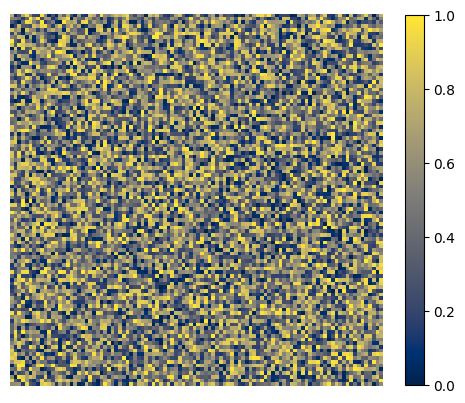

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from scipy.ndimage import gaussian_filter

# define parameters
k0 = 0.00625
k1 = 0.3125
k2 = 1
k3 = 0.0625
k4 = 0.05625
k5 = 0.0625
k6 = 0.02083
k7 = 0.001875
k8 = 0.140625
k9 = 0.25
k10 = 0.025

Drt = 0.08
Drd = 0.4
Df = 0.001 # 0-0.001

sigma = 0.75 # 0.5-1
s = 4
f = 10 # dW update frequency (seconds)

alpha = 1 # 0.5-1.5
beta = 1 # 0-2

size = 100 # number of cells
dt = 0.01  # time step
t = 1000.0 # run time
frame_int = 25 # animation frame interval

# set initial concentrations
RT = 0.1+0.9*np.random.rand(size,size)
RD = np.full((size, size),0.1)
F = np.full((size, size),0)

# generate correlated gaussian field for stochastic noise term
def correlated_gaussian_field(SIGMA=sigma, S=s, SHAPE=(size,size), MEAN=1.0):
    # apply Gaussian filter to random noise
    field = gaussian_filter(np.random.normal(0, 1, SHAPE), sigma=S, mode='wrap')
    # scale and shift for desired std and mean
    return MEAN + SIGMA * field / np.std(field)

# set initial stochastic noise term
dW = correlated_gaussian_field()

# define reaction function
def R(A,B,C):
    return (k0 + alpha*k1*A**3/(1 + k2*A**2))*B - (k3 + k4*(1 + beta)*C)*A

# approximate the laplacian with periodic boundaries and dx=dy=1
def periodic_laplacian(Z):
    return (np.roll(Z, 1, axis=1) + np.roll(Z, -1, axis=1) + np.roll(Z, 1, axis=0) + np.roll(Z, -1, axis=0) - 4*Z)

# set up figure
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('off')
frames = []

# colorbar
im = ax.imshow(RT, cmap='cividis', vmin=0, vmax=1, animated=True)
fig.colorbar(im, ax=ax, shrink=0.8)

# simulate the PDE with finite difference method
for i in range(int(t/dt)):

    # update concentrations
    RT = RT + dt * (R(RT,RD,F) + Drt*periodic_laplacian(RT))
    RD = RD + dt * (k5 - k6*RD - R(RT,RD,F) + Drd*periodic_laplacian(RD))
    F = F + dt * (k7 + k8*RT**2 / (1 + k9*RT**2) - k10*dW*F + Df*periodic_laplacian(F))

    # update stocastic noise term every f seconds
    if i % int(f/dt) == 0:
        dW = correlated_gaussian_field()

    # capture a frame every frame_int seconds
    if i % int(frame_int/dt) == 0:
        frames.append([ax.imshow(RT, cmap='cividis', animated=True)])

# save animation
animation.ArtistAnimation(fig, frames, interval=50, blit=True).save('RT_animation.gif', writer=PillowWriter(fps=10))